In [1]:
!pip uninstall -y sympy
!pip install sympy==1.12

# === Core Python Libraries ===
import numpy as np
import pandas as pd
from copy import deepcopy
import os
import random

# === Scientific Computing ===
from scipy import stats

# === Machine Learning Utilities ===
from sklearn.model_selection import train_test_split

# === Deep Learning ===
import torch
import torch.nn as nn

Found existing installation: sympy 1.13.3
Uninstalling sympy-1.13.3:
  Successfully uninstalled sympy-1.13.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 52.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [2]:
def seed_all(seed: int = 42, deterministic: bool = True):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

In [3]:
# === Set Seed for Reproducibility ===
seed_all()

# === Step 0–1: Load and Preprocess Raw Data ===
raw_url = "https://figshare.com/ndownloader/files/40584980"
All_Data = pd.read_csv(raw_url)
All_Data = All_Data.drop(['VL (M)', 'CD4 (M)'], axis=1)

All_Data.replace({
    "Gender":          {1: "Male", 2: "Female"},
    "Ethnic":          {1: "Asian", 2: "African", 3: "Caucasian", 4: "Other"},
    "Base Drug Combo": {0: "FTC + TDF", 1: "3TC + ABC", 2: "FTC + TAF", 3: "DRV + FTC + TDF", 4: "FTC + RTVB + TDF", 5: "Other"},
    "Comp. INI":       {0: "DTG", 1: "RAL", 2: "EVG", 3: "Not Applied"},
    "Comp. NNRTI":     {0: "NVP", 1: "EFV", 2: "RPV", 3: "Not Applied"},
    "Extra PI":        {0: "DRV", 1: "RTVB", 2: "LPV", 3: "RTV", 4: "ATV", 5: "Not Applied"},
    "Extra pk-En":     {0: "False", 1: "True"}
}, inplace=True)

All_Data = All_Data.drop(columns=['Drug (M)'])

In [4]:
All_Data[All_Data["PatientID"] == 0].head()

,VL,CD4,Rel CD4,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,PatientID,Timestep
0,29.944271,793.45830,30.834505,Male,Caucasian,FTC + TDF,DTG,Not Applied,Not Applied,False,0,0
1,29.241980,467.41890,30.355980,Male,Caucasian,FTC + TDF,DTG,Not Applied,Not Applied,False,0,1
2,28.748991,465.12485,30.405320,Male,Caucasian,FTC + TDF,DTG,Not Applied,Not Applied,False,0,2
3,28.101835,692.00690,30.248816,Male,Caucasian,FTC + TDF,DTG,Not Applied,Not Applied,False,0,3
4,28.813837,641.75714,29.944712,Male,Caucasian,FTC + TDF,DTG,Not Applied,Not Applied,False,0,4


In [5]:
All_Data[All_Data["PatientID"] == 0].shape[0]

60

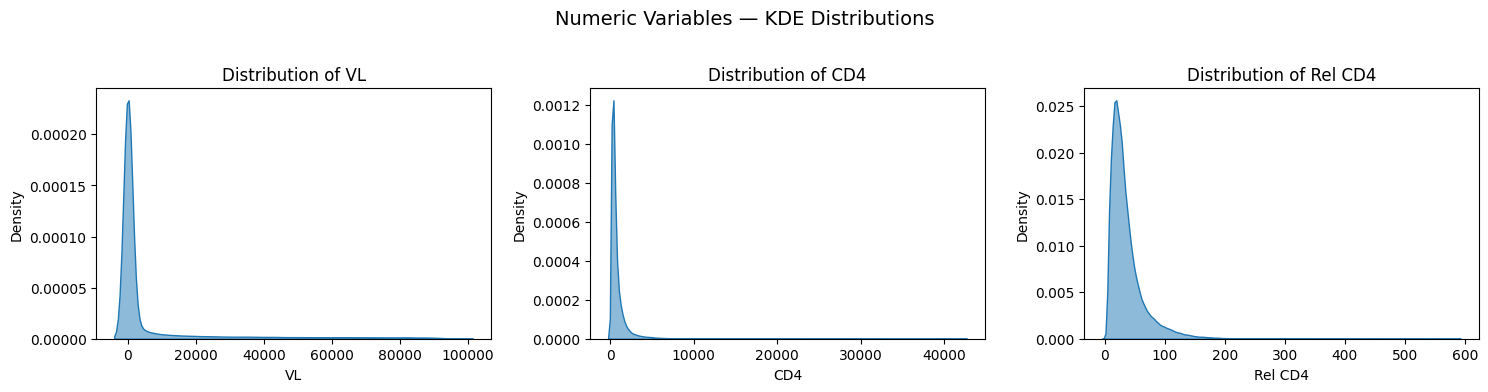

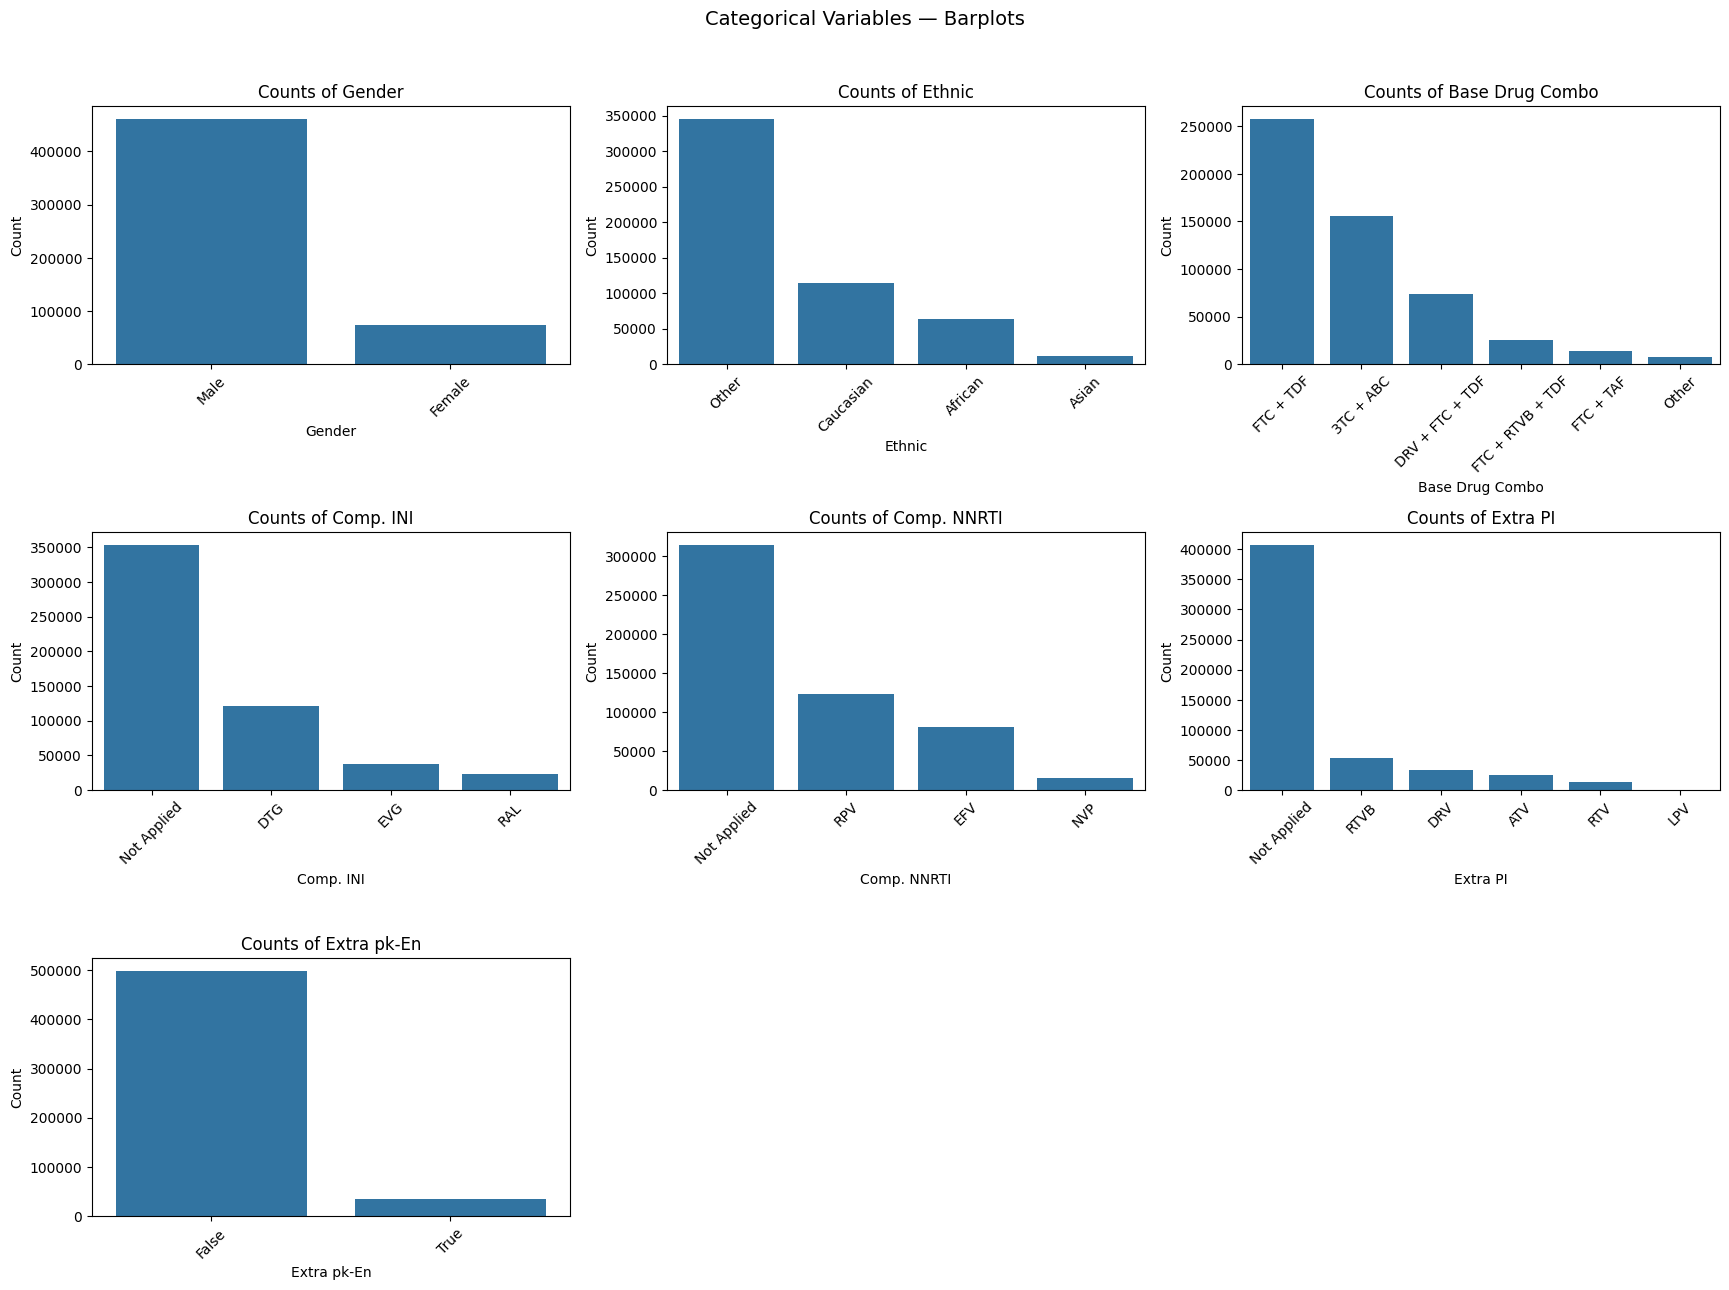

In [6]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Exclusions (case-insensitive, with a regex safety net) --------
EXCLUDE_NAMES = {"patientid", "timestep"}
EXCLUDE_REGEX = re.compile(r"(?:^|_)id$|patient.*id|^timestep$", re.IGNORECASE)

def should_exclude(col: str) -> bool:
    cl = col.lower()
    return (cl in EXCLUDE_NAMES) or bool(EXCLUDE_REGEX.search(col))

# Identify numeric and categorical columns with exclusions applied
numeric_cols = [c for c in All_Data.select_dtypes(include=[np.number]).columns if not should_exclude(c)]
categorical_cols = [c for c in All_Data.select_dtypes(include=["object", "category"]).columns if not should_exclude(c)]

# Safety check: ensure excluded columns are not in either list
assert all(not should_exclude(c) for c in numeric_cols), "An excluded numeric column slipped through."
assert all(not should_exclude(c) for c in categorical_cols), "An excluded categorical column slipped through."

# -------- Plot settings --------
MAX_COLS_PER_ROW = 3

# ==============================
# Numeric distributions (KDEs)
# ==============================
if numeric_cols:
    n_num = len(numeric_cols)
    ncols = min(MAX_COLS_PER_ROW, n_num)
    nrows = math.ceil(n_num / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.array(axes).reshape(-1) if nrows*ncols > 1 else np.array([axes])

    for ax, col in zip(axes, numeric_cols):
        x = All_Data[col].dropna().astype(float)
        if x.nunique() <= 1:
            ax.hist(x, bins=10)
            ax.set_title(f"{col} (constant/near-constant)")
            ax.set_xlabel(col); ax.set_ylabel("Count")
        else:
            try:
                sns.kdeplot(x=x, fill=True, alpha=0.5, ax=ax)
                ax.set_title(f"Distribution of {col}")
                ax.set_xlabel(col); ax.set_ylabel("Density")
            except Exception:
                ax.hist(x, bins=30, density=True, alpha=0.6)
                ax.set_title(f"Distribution of {col} (hist fallback)")
                ax.set_xlabel(col); ax.set_ylabel("Density")

    for ax in axes[n_num:]:
        ax.axis("off")

    fig.suptitle("Numeric Variables — KDE Distributions", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()

# ==============================
# Categorical distributions (Barplots)
# ==============================
if categorical_cols:
    n_cat = len(categorical_cols)
    ncols = min(MAX_COLS_PER_ROW, n_cat)
    nrows = math.ceil(n_cat / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.8*ncols, 4.2*nrows))
    axes = np.array(axes).reshape(-1) if nrows*ncols > 1 else np.array([axes])

    for ax, col in zip(axes, categorical_cols):
        order = All_Data[col].value_counts(dropna=False).index
        sns.countplot(data=All_Data, x=col, order=order, ax=ax)
        ax.set_title(f"Counts of {col}")
        ax.set_xlabel(col); ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    for ax in axes[n_cat:]:
        ax.axis("off")

    fig.suptitle("Categorical Variables — Barplots", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()
